# Dynamic Mode Decomposition #
$\newcommand{\mb}[1]{\textbf{#1}} \newcommand{\mbs}[1]{\boldsymbol{#1}}$
The following is based on the book *Dynamic Mode Decomposition by J. Nathan Kutz et al.*. Consider a general nonlinear dynamical system with states $\textbf{x} \in R^n$ for some additional parameters $\mu$.
$$ \frac{d\textbf{x}}{dt} = \textbf{f}(\textbf{x}, t, \mu) $$
The problem can also be written in discrete form for time steps $k = 1, ..., M$. 
$$ \textbf{x}_{k+1} = F(\textbf{x}_k) $$
Consider observables $g(\textbf{x}_k)$ in the system. The Koopman operator $\mathcal{K}$ is a linear map on an infinite dimensional Hilbert space $\mathcal{H}$ which evolves any observables in time (including measuring the state $\textbf{x}$ and evolving it in time). 
$$ \mathcal{K} g(\textbf{x}_k) = g(\textbf{F}(\textbf{x}_k)) = g(\textbf{x}_{k+1}) $$
Dynamic mode decomposition is a finite approximation to the Koopman operator for evolving the state variables $\textbf{x}$ further in time, $\textbf{x} \in R^N$. A linear model is chosen to fit the dynamics.
$$ \textbf{x}_{k+1} = \textbf{A} \textbf{x}_k $$
Where the matrix $\textbf{A}$ is best-fit among a number of snapshot observations and collected into matrices $\textbf{X} = \{\textbf{x}_1, \textbf{x}_2, ..., \textbf{x}_{M-1}\}$ and $\textbf{X}' = \{\textbf{x}_2, \textbf{x}_3, ..., \textbf{x}_{M}\}$. The residual in the snapshot equation $\textbf{X}' = \textbf{A} \textbf{X}$ is minimized among all time steps.
$$ \min_{\textbf{A}} \sum_{k=1}^{M-1} |\textbf{x}_{k+1} - \textbf{A} \textbf{x}_{k}|^2 \equiv \min_{\textbf{A}} |\textbf{X}' - \textbf{A} \textbf{X}|_F^2$$
The optimal $\textbf{A}$ matrix is given by the Moore-Penrose pseudo-inverse $\textbf{A} = \textbf{X}' \textbf{X}^{\dagger}$. First, I generate a nonlinear dynamics problem that has nonlinear spatial and temporal behavior. After that, we will compute the SVD to get low-rank approximations of the dynamics described by $\textbf{A} \textbf{x} \rightarrow \textbf{x}'$. 

F shape = (800, 400)


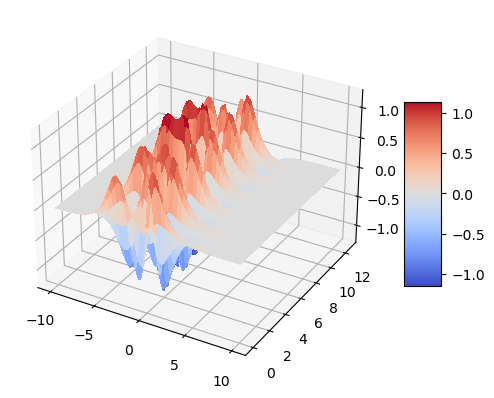

In [12]:
"""
Dynamic matrix decomposition example from Ch. 1, p. 11,
book Dynamic Mode Decomposition by Kutz et al.
"""

import numpy as np, matplotlib.pyplot as plt
from matplotlib import cm

nx = 800; nt = 400
xvec = np.linspace(-10, 10, nx)
t = np.linspace(0, 4*np.pi, nt)
dt = t[1] - t[0]
Xpos, T = np.meshgrid(xvec, t)

# generate the function f(x,t) "spatio-temporal pattern"
# on the grid with f(x,t) = f1(x,t) + f2(x,t)
# f1(x,t) = sech(x+3)*exp(i*2.3*t) + 2 * sech(x)*tanh(x)*exp(i*2.8*t)
# treat the data F = [f(:,t1), f(:,t2), ..., f(:,tM-1)] as the snapshots for DMD, etc.

f1 = 1.0/np.cosh(Xpos+3) * np.exp(1j * 2.3 * T)
f2 = 2.0/np.cosh(Xpos) * np.tanh(Xpos) * np.exp(1j * 2.8 * T)
f1 = np.real(f1); f2 = np.real(f2)
F = (f1 + f2).T
print(f"F shape = {F.shape}")

# plot the original nonlinear dataset
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(Xpos, T, F.T, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

## DMD Algorithm ##
Compute the SVD of $\mb{X} \approx \mb{U} \mbs{\Sigma} \mb{V}^*$ where $\mb{U} \in C^{nxr}, \mbs{\Sigma} \in C^{rxr}, \mb{V} \in C^{mxr}$ and $r$ is the size of the low-rank approximation. The matrices $\mb{U}, \mb{V}$ are unitary meaning $\mb{U}^* \mb{U} = \mb{V}^* \mb{V} = \mb{I}$. The matrix $\mb{A}$ using the SVD is then:
$$ \mb{A} = \mb{X}' \mb{V} \mbs{\Sigma}^{-1} \mb{U}^* $$
The low-rank approximation to $\tilde{\mb{A}}$, below, is used for a low-rank approximation of the dynamics. The full state is obtained with $\mb{x}_k = \mb{U} \tilde{\mb{x}}_k$. 
$$ \tilde{\mb{x}}_{k+1} = \tilde{\mb{A}} \tilde{\mb{x}}_k $$
The low-rank dynamics matrix is given by:
$$ \tilde{\mb{A}} = \mb{U}^* \mb{X}' \mb{V} \mbs{\Sigma}^{-1} $$
The eigendecomposition of $\tilde{\mb{A}}$ is necessary to eventually compute the full-scale eigenmodes and eigenvalues. We have eigenvectors $\mb{W}$ and eigenvalues $\mbs{\Lambda}$.
$$ \tilde{\mb{A}} \mb{W} = \mb{W} \mbs{\Lambda} $$
The eigenvectors of $\mb{A}$ are then. Another way to compute eigenmodes is $\mbs{\Phi} = \mb{U} \mb{W}$ however these are less accurate (the projected modes). 
$$ \mbs{\Phi} = \mb{X}' \mb{V} \mbs{\Sigma}^{-1} \mb{W} $$
The ROM then gives:
$$ \tilde{\mb{x}}_{k+1} = \tilde{\mb{A}} \tilde{\mb{x}}_k \quad \land \quad\mb{x}_k = \mb{U} \tilde{\mb{x}}_k $$
We now apply the DMD algorithm to extract low-rank approximations to the above nonlinear dataset. Below the snapshop matrices are $\textbf{F}, \textbf{F}'$ since $\textbf{f}(x, t)$ is actually the state variable here. The full dynamics in continuous time is then given by:
$$ \textbf{x}(t) = \Phi \textrm{exp}(\mbs{\Omega} t) \mb{b} $$
However these eigenvalues $\Omega \equiv \omega_k$ are related to those of $\tilde{\mb{A}}$ by $\omega_k = \log{\lambda_k}/ \Delta t$. 
$$ \textbf{x}(t) = \Phi \textrm{exp}(\mbs{\Lambda} t) \mb{b} $$
Where $\mb{b} = \mbs{\Phi}^{\dagger} \mb{x}_1$ is found using the pseudo-inverse on the initial condition.

SVD resid norm = 1.2590635700368022
SVD resid = [[ 0.00164091  0.00162875  0.00160863 ... -0.00145311 -0.00139523
  -0.00133054]
 [ 0.0016825   0.00167004  0.0016494  ... -0.00148994 -0.00143059
  -0.00136426]
 [ 0.00172515  0.00171237  0.00169121 ... -0.00152771 -0.00146686
  -0.00139884]
 ...
 [ 0.00019736  0.0001951   0.00019136 ... -0.00017811 -0.00016987
  -0.00016034]
 [ 0.00019248  0.00019028  0.00018663 ... -0.00017371 -0.00016567
  -0.00015637]
 [ 0.00018772  0.00018558  0.00018202 ... -0.00016941 -0.00016158
  -0.00015251]]
Eigenvalues = [-128.69169731+56.13294043j -128.69169731-56.13294043j]


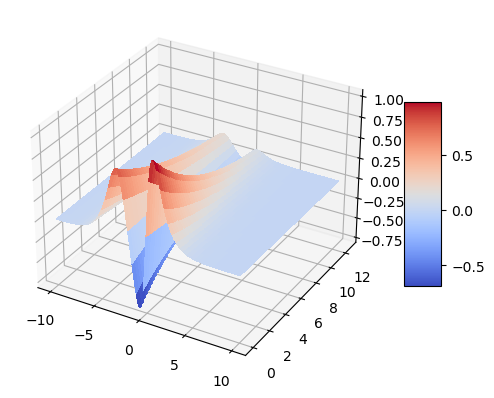

In [11]:
import scipy as sp
# snapshot matrices Fi => Fp, and Fp ~ A * Fi
Fp = F[:,1:]
Fi = F[:, :nt-1]

## rank-2 SVD
r = 2
U, S, V = np.linalg.svd(Fi, full_matrices=False)
Ur = U[:, :r]; Vr = V[:, :r]; Sr = np.diag(S[:r])
Sr_inv = np.diag(1.0/S[:r])

# evaluate the SVD residual
Apinv = Fp @ np.linalg.pinv(Fi)
norm1 = Fp - Apinv @ Fi
A = Fp @ Vr @ Sr_inv @ Ur.T
SVD_resid = Fp - A @ Fi
SVD_resid_norm = np.max(np.abs(SVD_resid))
print(f"SVD resid norm = {SVD_resid_norm}")
print(f"SVD resid = {SVD_resid}")

# low-rank matrix Ar and eigenvalues of Ar (or Atilde)
Ar = Ur.T @ Fp @ Vr @ Sr_inv
lambdas, W = np.linalg.eig(Ar)
# DMD modes of A
Phi = Fp @ Vr @ Sr_inv @ W

# DMD spectra
Omega = np.diag(np.log(lambdas)/ dt) ;
print(f"Eigenvalues = {np.log(lambdas)/dt}")
b = np.linalg.pinv(Phi) @ F[:, 0:1]


# Full DMD mode reconstruction
Fdmd_r = np.zeros((r, nt), dtype=np.complex128)
for it in range(nt):
    Fdmd_r[:, it] = np.exp(Omega * t[it]) @ b[:,0]
Fdmd = np.real(Phi @ Fdmd_r)

# compare solution with Apinv method
Fdmd2 = np.zeros((nx, nt))
Fdmd2[:,0] = F[:,0]
for it in range(1, nt):
    Fdmd2[:,it] = Apinv @ Fdmd2[:, it-1]

# plot the full DMD
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(Xpos, T, Fdmd2.T, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()